In [674]:
# Libraries Block
import importlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
%matplotlib inline
import dill
import pickle
import matplotlib.lines as mlines
import matplotlib
import seaborn as sns
import pandas as pd

In [675]:
# Imports of existent functions in separated python files. 
#  Every time this block is executed, it reloads the imports (for possible file changes).

# This function simply returns a list (s0,s1,...,sn) in pairs such that [(s0,s1),(s1,s2),...,(sn-1,sn)]
import zmod_pairwise
importlib.reload(zmod_pairwise)

# [MFC] This has all the logic to automatically download street graph of any city with precise 5x5 elevation data for each node.
#  For the moment, only available for Spain cities as elevation is gathered from National Geographic Institute.
import zmod_elevation
importlib.reload(zmod_elevation)

# Loads JSON water usages and applies particularities.
# It links the json consumptions to nodes in the city street graph.
import zmod_consumptions
importlib.reload(zmod_consumptions)

# It prints detailed network design results in PDF format.
import zmod_print
importlib.reload(zmod_print)

# It contains the logic to compute normal and weighted availability.
import zmod_availability
importlib.reload(zmod_availability)

# It contains all the construction costs related logic.
import zmod_costs
importlib.reload(zmod_costs)

# It contains all algorithms logic, precomputation of data, and main algorithms.
import zmod_algorithms
importlib.reload(zmod_algorithms)

# It contains all the EPANET construction and execution.
import zmod_epanet
importlib.reload(zmod_epanet)


<module 'zmod_epanet' from '/home/david.ma/water-networks-reliability-optimization/zmod_epanet.py'>

In [3]:
# Variables. Sets the name of the place, the place of the source tank, 
#  and if we want to print statistics on city graph gathering.
# Also set the name of water usages file.

#place = "el Prat de Llobregat" # Prat
#place = "Lloret de Mar" # Lloret
place = "Girona" # Lloret

#source_place = [42.024292, 2.831517] # Girona
#source_place = [41.31247687927103, 2.1262720406050524] # Prat
source_place = [41.9969803, 2.8143168] # Girona Barri 4 (Budgeted Algorithm Domeny).

#source_place = (41.9740027,2.8248944) # Sector Montilivi
#source_place = (41.9908609,2.8267669) # Sector Montjuïc
#source_place = [41.9624659,2.8129656] # Sector Palau

#source_place = (41.715223, 2.822544) # Lloret

printStatistics = False

usages_file = './json-usages/gironaAllUsages.json'

In [96]:
# [MFC] Gather the city street graph with elevations.
# [MFC] This has all the logic to automatically download street graph of any city with precise 5x5 elevation data for each node.
#  For the moment, only available for Spain cities as elevation is gathered from National Geographic Institute.
g = zmod_elevation.elevationIGN(place, printStatistics)

# Information prints.
print("Number of nodes:",len(g.nodes()))
print('Graph generation completed.')

/home/david.ma/anaconda3/envs/ox/lib/python3.11/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'servicios.idee.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/david.ma/anaconda3/envs/ox/lib/python3.11/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'servicios.idee.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Showing results with 5m precision
Number of nodes: 2728
Graph generation completed.


In [15]:
# Save the original graph in a pickle.
with open('./pickles/girona_raw.pkl', 'wb') as f:
    pickle.dump(g, f)

In [4]:
# Load the raw graph pickle.
g = dill.load(open("./pickles/girona_raw.pkl", "rb"))
print(len(g.nodes()))

2728


In [112]:
# Loads JSON water usages and applies particularities.
# It links the json consumptions to nodes in the city street graph.
g_attr = zmod_consumptions.link_json_consumptions(g,usages_file)

JSON usages linked successfully.


In [113]:
# Public garden information gathering. Gets all public green areas, which we suppose needs irragation.
g_attr = zmod_consumptions.link_publicgarden_consumptions(g_attr, place)

Public gardens consumption: 399.99 m3/day
Public gardens area: 951,602.94 m2
Public gardens linked successfully.


In [114]:
# [DMA] Print the total consumption.
total_consumption = 0
for node, node_d in g_attr.nodes(data = True):
    total_consumption += node_d["consumption"]
    
print("Total consumption:",'{:,.2f}'.format(total_consumption*365),"m3/year")
print("Total consumption:",'{:,.2f}'.format(total_consumption),"m3/day")

Total consumption: 9,332,985.51 m3/year
Total consumption: 25,569.82 m3/day


In [15]:
# [DMA] Save the graph in a pickle.
with open('./pickles/girona_usages.pkl', 'wb') as f:
    pickle.dump(g_attr, f)

In [480]:
# [DMA] Load the graph pickle.
g_attr = dill.load(open("./pickles/girona_usages.pkl", "rb"))

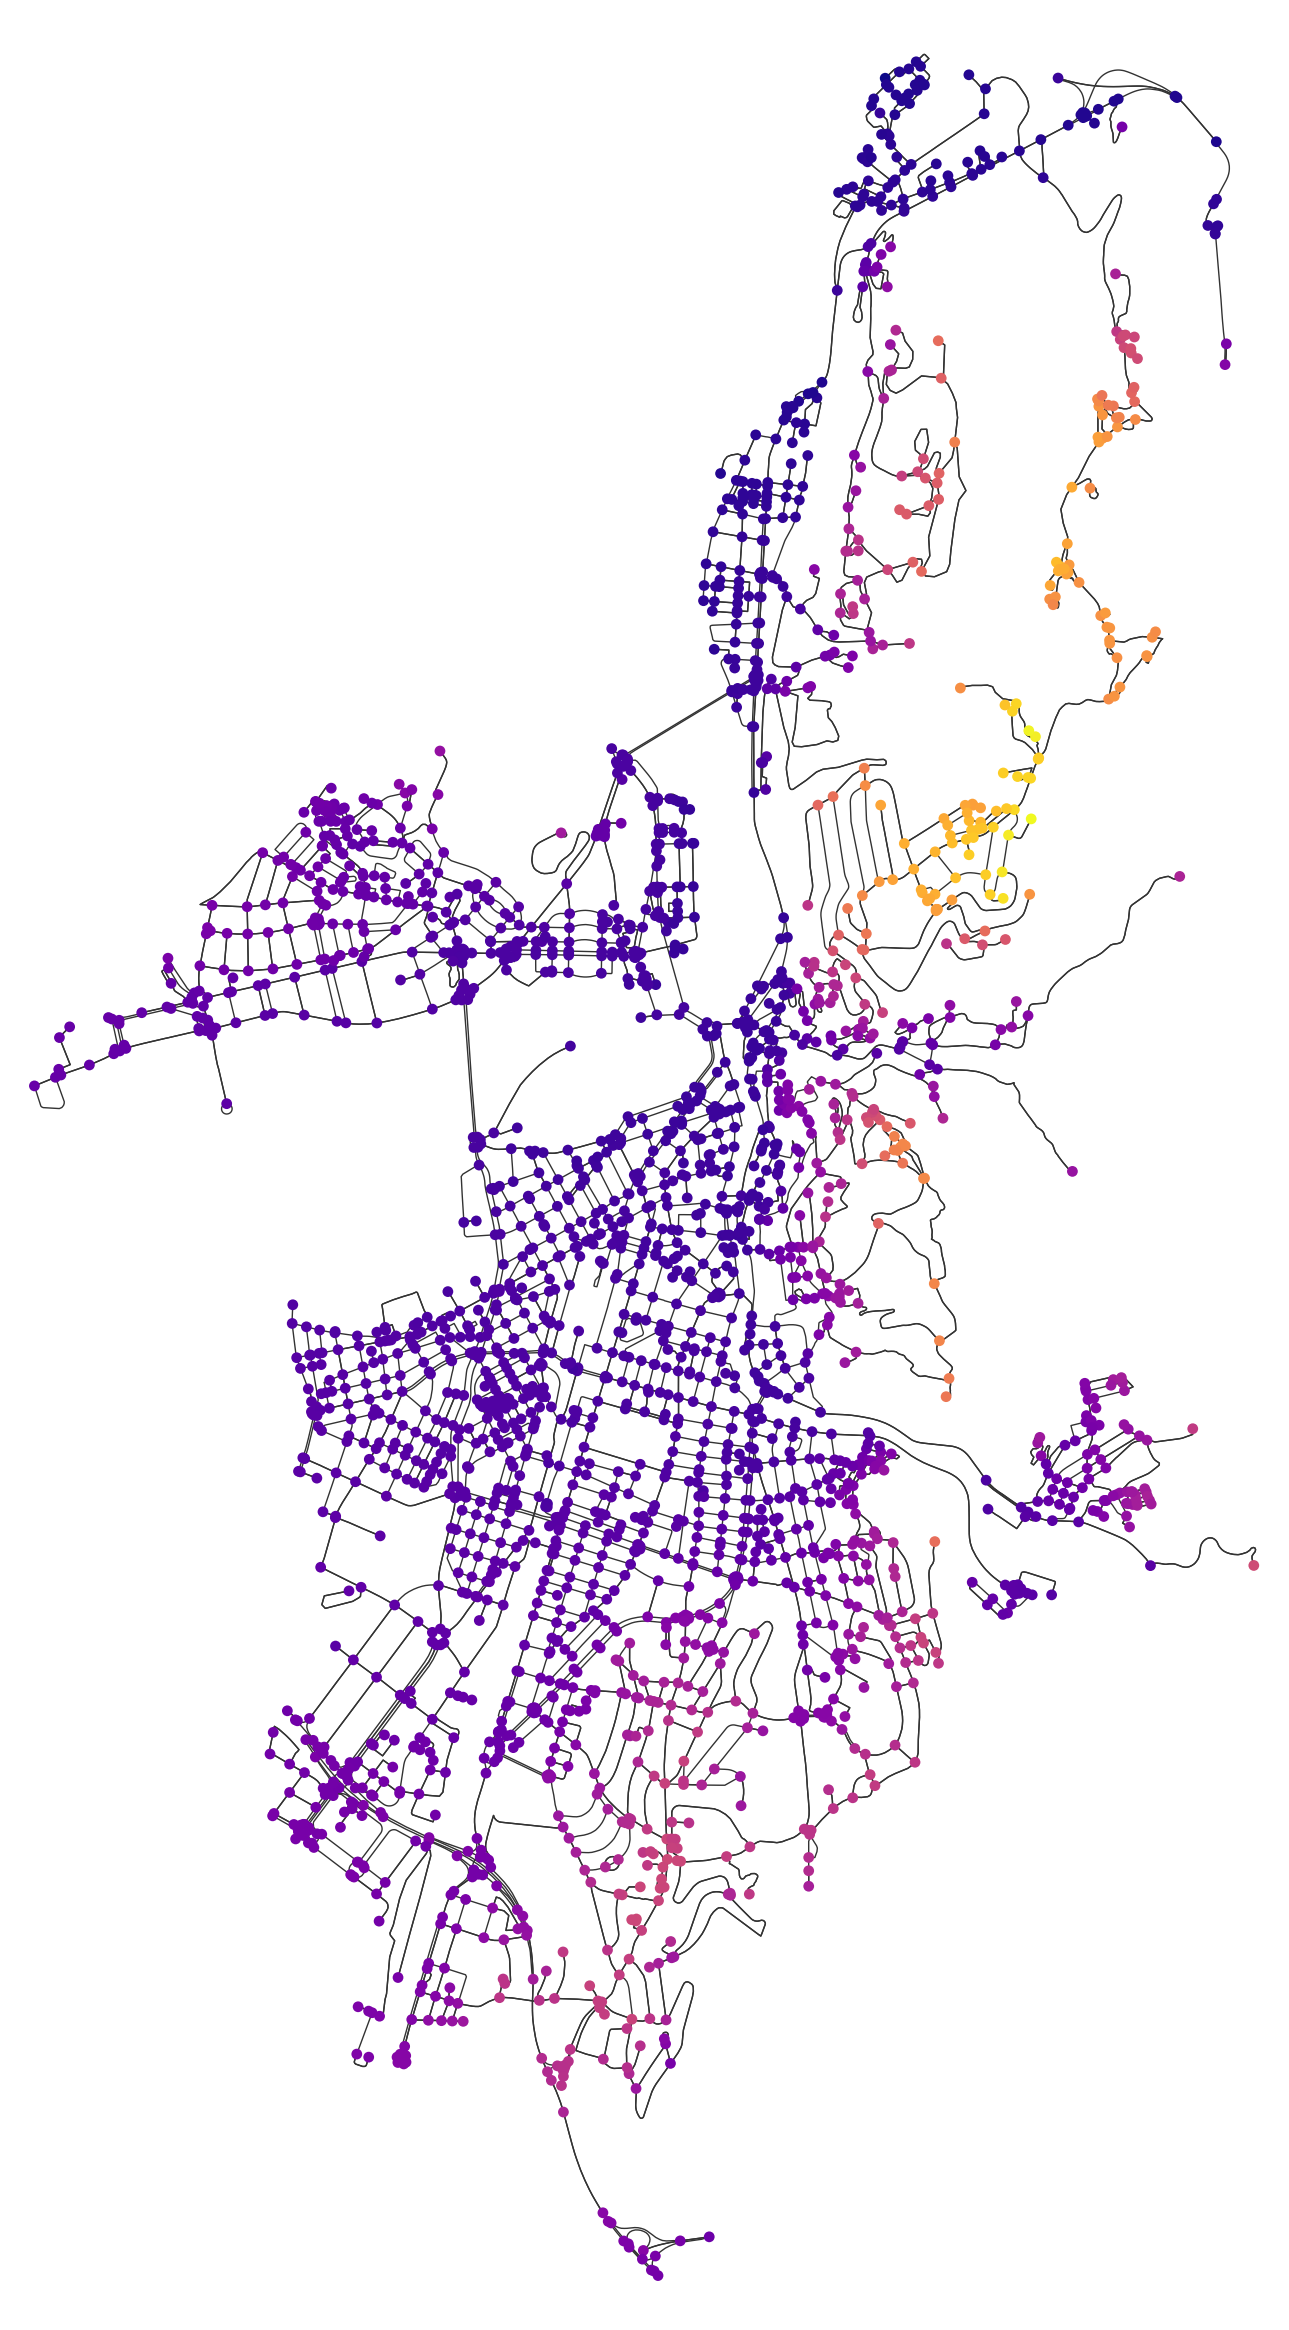

In [75]:
# [DMA] Print the consumption graph (blue: less consumption; red: most consumption).
nc = ox.plot.get_node_colors_by_attr(g_attr, 'elevation', cmap=plt.get_cmap('plasma'))
fig, ax = ox.plot_graph(g_attr, node_color=nc, node_size=60, figsize=(30,30), edge_color='#333333', bgcolor='#ffffff00',
                       save=True, dpi=300, filepath='./pdfs/scenario.pdf')
#fig, ax = ox.plot_graph(g_attr, node_color=nc, node_size=60, figsize=(30,30), edge_color='#333333', bgcolor='#ffffff00',
#                       save=True, dpi=150, filepath='./jpgs/scenario.jpg')
#handles, labels = ax.get_legend_handles_labels()
#handles.append(mlines.Line2D([0], [0], color='white', marker='D', markersize=15, markerfacecolor='black',
#                                 label='Elevation'))
#plt.legend(handles=handles, loc="upper left", prop={'size': 20})


In [485]:
travel_times = {}

In [486]:
# Get the pre-computed data structures to be ready to compute LB algorithm.
wwtp = ox.nearest_nodes(g_attr, source_place[1], source_place[0])
g_attr_new = nx.Graph(g_attr)
precomputed_data = 0
%time precomputed_data = zmod_algorithms.precompute_data_lb_algorithms(g_attr_new)

CPU times: user 1min 2s, sys: 440 ms, total: 1min 2s
Wall time: 1min 2s


In [678]:
# Execute the optimized LBR (LB Resilient) algorithm.
#name = "resilient"
#title = "Resilient by design"
#num = "1"
name = "nonresilient"
title = "Non-resilient"
num = "2"

#budgets = [500000,750000,1000000,1250000,1500000,1750000,2000000]
#budgets = [500000, 750000, 1000000,1250000,1500000]
# Strengthened is 1876982€
budgets = [1135000]
#budgets = [1500000]
wwtp = ox.nearest_nodes(g_attr, source_place[1], source_place[0])
result_graphs = []
result_datas = []
result_epanets = []
for b in budgets:
    print("Computing LBR for budget:",b)
    g_attr_new = nx.Graph(g_attr)
    #result_graph, result_data, result_epanet = zmod_algorithms.lbr_algorithm_hydraulic(g_attr_new, b, wwtp, precomputed_data)
    result_graph, result_data, result_epanet = zmod_algorithms.lb_algorithm_v1_efficient_hydro(g_attr_new, b, wwtp, precomputed_data)
    print(" - Failure rate is",result_data["failure_rate"])
    result_graphs.append(result_graph)
    result_datas.append(result_data)
    result_epanets.append(result_epanet)

Computing LBR for budget: 1135000
 - Failure rate is 0.1752284263959391


For budget 1135000 :
 - Pipe network length: 10356 m.
 - Water served: 1535.8964396882893 m3/day.
 - Percentage served: 21.5 %.
 - Execution time: 14.305790185928345 s.


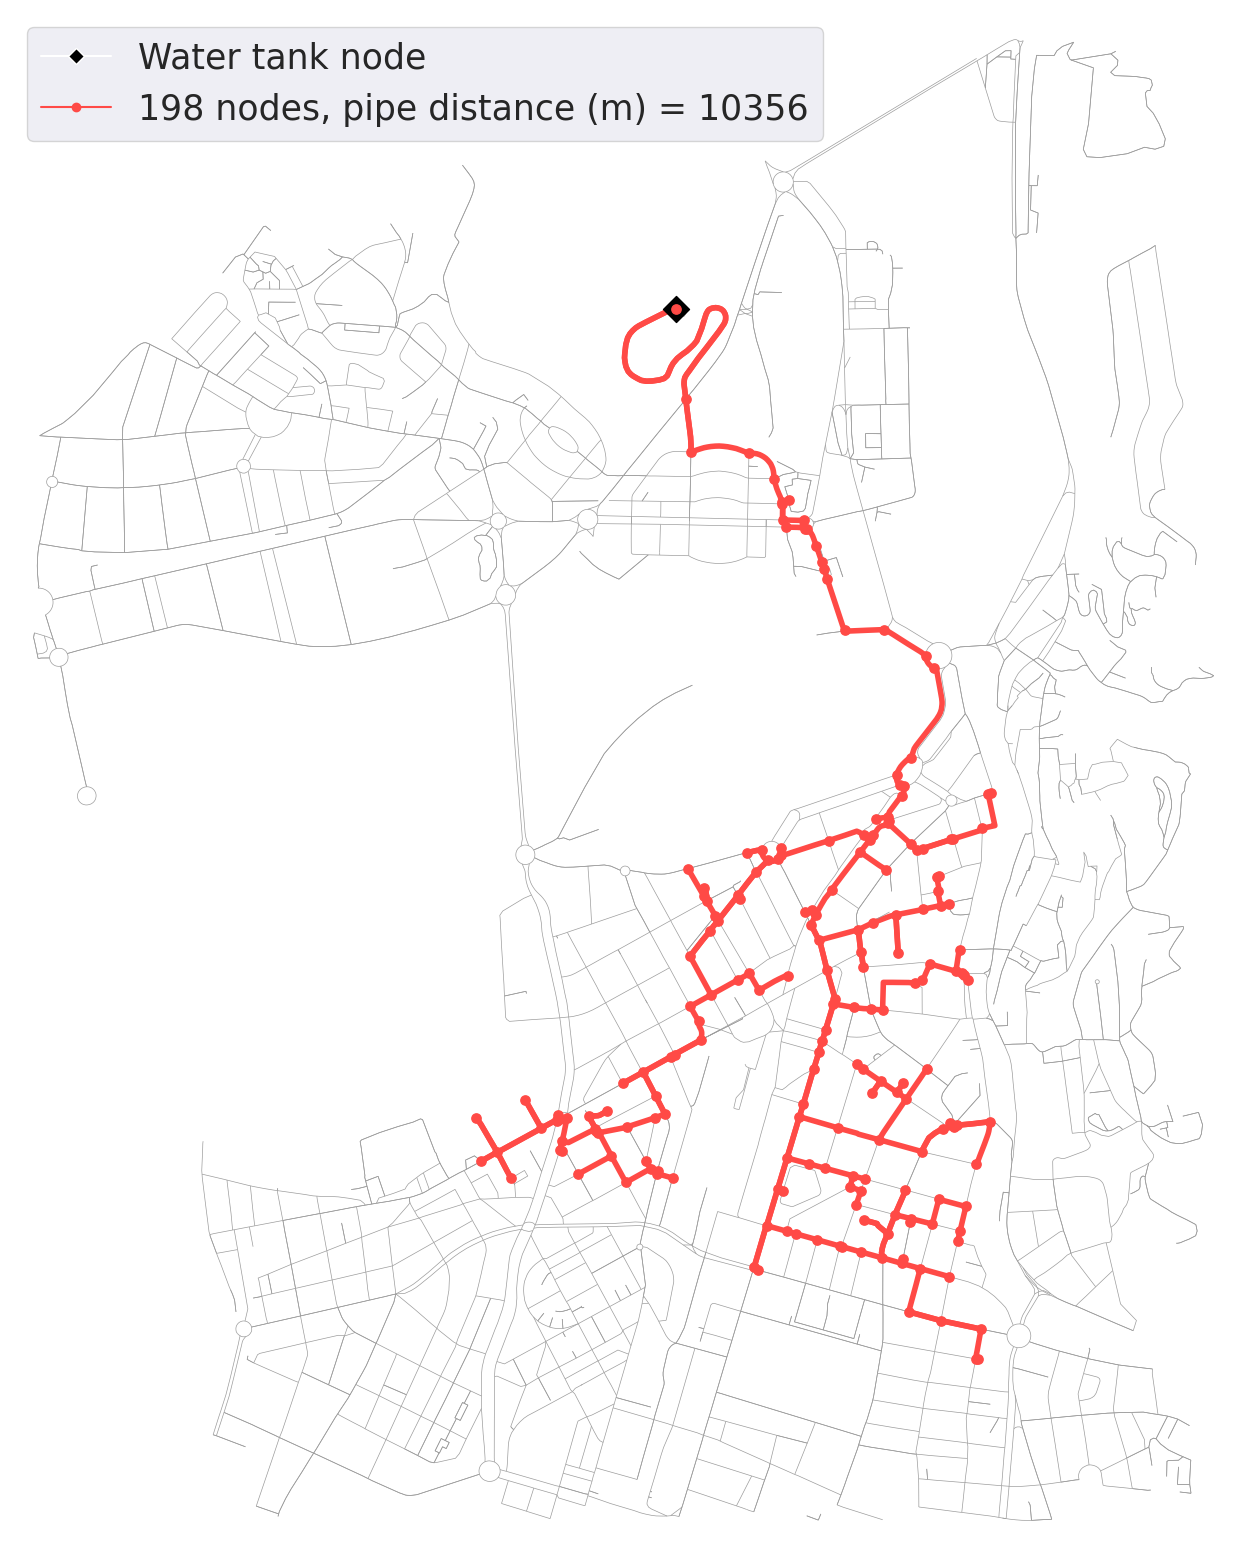

Running EPANET 2.2 ...
 - EPANET ran successfully
- Seems the output is OK, network is feasible.
To close: []
{'success': True, 'max_pressure': 46.78, 'min_pressure': 29.13, 'max_speed': 0.98, 'min_speed': 0.02, 'unsupplied_nodes': set()}


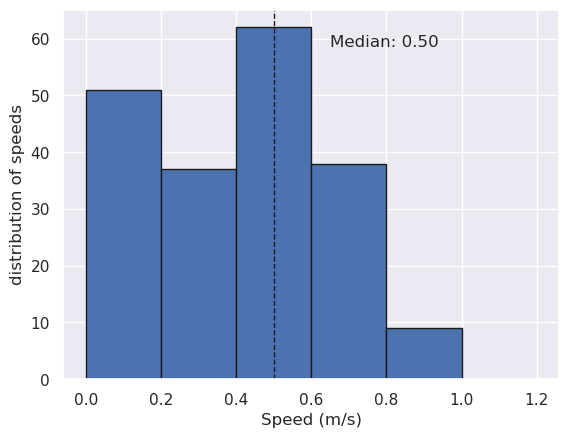

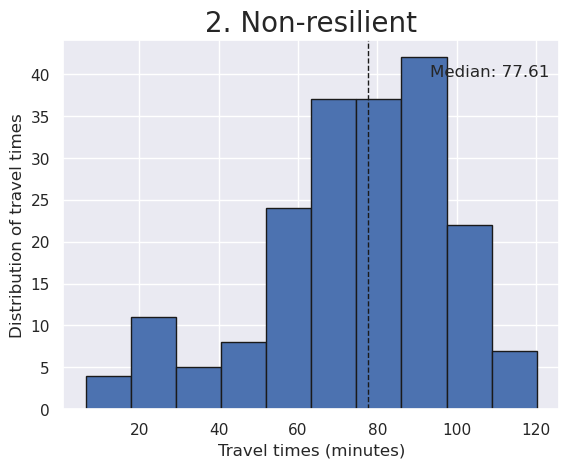

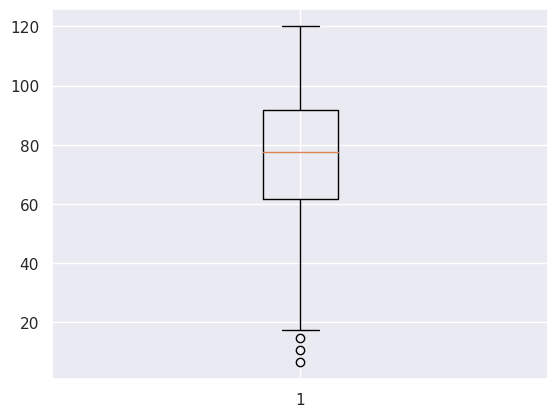

Maximum travel time (min): 120.14
***********************************************************************



In [679]:
# Print results in PDF and Folium html. Then, show also statistics.
for i in range(0,len(result_graphs)):
    graph = result_graphs[i]
    result_data = result_datas[i]
    result_epanet = result_epanets[i]
    
    print("For budget",budgets[i],":")
    print(" - Pipe network length:",result_data["pipe_distance"],"m.")
    print(" - Water served:",result_data["total_cons"],"m3/day.")
    print(" - Percentage served:",result_data["percentage_served"],"%.")
    #print(" - Network availability:",result_data["availability"])
    print(" - Execution time:",result_data["execution_time"],"s.")

    # Plot the network obtained with the LBR algorithm, both folium HTML and PDF.
    #zmod_print.plot_network_with_folium(nx.Graph(g_attr), graph, wwtp, precomputed_data, filepath="htmls/epanet_mesh_"+str(budgets[i]))
    zmod_print.print_solution_small(nx.MultiDiGraph(g_attr), wwtp, result_data["added_nodes"], wwtp, graph, filename="./pdfs/aa_"+name)

    # For each edge save the flow, velocity, headloss, and travel time. If velocity is 0, then close the edge.
    attrs = {}
    to_close = []
    node_data, link_data, epanet_result_data = zmod_epanet.compute_epanet(graph, result_data["tank_capacity"], wwtp, True)
    for u,v,data in graph.edges(data=True):
        if link_data[(u,v)]["velocity"] > 0:
            travel_time = round(data["length"]/link_data[(u,v)]["velocity"]/60,2)
            attrs[(u,v)] = {
                "velocity": link_data[(u,v)]["velocity"],
                "pre_flow": round(data["flow"],2),
                "flow": link_data[(u,v)]["flow"],
                "headloss": link_data[(u,v)]["headloss"],
                "travel_time": travel_time,
                "popup_folium": "Diameter (mm): "+str(data["diameter"])+". Velocity (m/s): "+str(link_data[(u,v)]["velocity"])+". EPANET Flow (m3/d): "+str(abs(link_data[(u,v)]["flow"]))+". Predicted flow (m3/d): "+str(round(data["flow"],2))+". Pipe length (m): "+str(data["length"])+". Travel time (min): "+str(travel_time)+"."
            }
        else:
            attrs[(u,v)] = {
                "velocity": 0, 
                "flow": 0,
                "pre_flow": 0,
                "travel_time": 0,
                "popup_folium": "Closed Pipe (CP). Diameter (mm): "+str(data["diameter"])+". Pipe length (m): "+str(data["length"])+"."
            }
            to_close.append((u,v))
    print("To close:",to_close)
    nx.set_edge_attributes(graph, attrs)
    
    # Show EPANET summary result data.
    print(epanet_result_data)
    
    # Generate the resulting network in folium.
    zmod_print.plot_network_with_folium_epanet(nx.Graph(g_attr), graph, wwtp, precomputed_data, node_data, link_data, epanet_result_data["unsupplied_nodes"], "./htmls/aa_"+name)
    zmod_print.plot_network_with_folium_valves(nx.Graph(g_attr), graph, wwtp, node_data, "./htmls/aa_"+name+"valves")
    
    # Show a velocity histogram for information purposes.
    velocities = []
    for link in link_data:
        velocities.append(link_data[link]['velocity'])
    bins = np.array([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2])
    plt.hist(velocities, bins=bins, edgecolor = 'k', range = (0,1.2))
    plt.axvline(np.median(velocities), color='k', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(np.median(velocities)*1.3, max_ylim*0.9, 'Median: {:.2f}'.format(np.median(velocities)))
    plt.xlabel('Speed (m/s)')
    plt.ylabel('distribution of speeds')
    plt.show()
    
    #  Generate a directed graph according to the flow values.
    #  - The directed graph will be used to compute exploration time for each node.
    directed_graph = nx.DiGraph()
    for u,v,data in graph.edges(data=True):
        flow = data['flow']
        if flow >= 0:
            directed_graph.add_edge(u, v)
        else:
            directed_graph.add_edge(v, u)
    visited_nodes = set()
    expl_times = []
    stack = [(wwtp, 0)]
    result = {}
    while stack:
        current_node, current_time = stack.pop()
        if current_node not in visited_nodes:
            visited_nodes.add(current_node)
            accumulated_time = current_time
            for neighbor in directed_graph.neighbors(current_node):
                travel_time = graph[current_node][neighbor]['travel_time']
                if travel_time > 0:
                    total_time = round(accumulated_time + travel_time,2)
                    if neighbor in result and total_time > result[neighbor]:
                            result[neighbor] = total_time
                    else:
                        result[neighbor] = total_time
                    expl_times.append(total_time)
                    stack.append((neighbor, total_time))
    travel_times[name] = expl_times
    plt.hist(expl_times, edgecolor = 'k')
    plt.axvline(np.median(expl_times), color='k', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(np.median(expl_times)*1.2, max_ylim*0.9, 'Median: {:.2f}'.format(np.median(expl_times)))
    plt.xlabel('Travel times (minutes)')
    plt.ylabel('Distribution of travel times')
    plt.title(num+". "+title, size=20)
    plt.savefig('pdfs/aa_traveltimes_'+name+'.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()
    plt.boxplot(expl_times)
    plt.show()
    print('Maximum travel time (min):',max(expl_times))
    print("***********************************************************************")
    print()

In [648]:
# Compute availability
for i in range(0,len(result_graphs)):
    graph = result_graphs[i]
    result_data = result_datas[i]
    result_epanet = result_epanets[i]

    result_data["availability"] = zmod_availability.new_availability_weighted(result_graph,precomputed_data,result_data["cons_nodes"],100000,result_data["failure_rate"],wwtp, g_attr_new, result_epanet)
    print(result_data["availability"])
    #result_data["availability"] = zmod_availability.old_availability_weighted(result_graph,precomputed_data,result_data["cons_nodes"],10000,result_data["failure_rate"],wwtp, g_attr_new, result_epanet)
    #print(result_data["availability"])

Pipe failure probabilities (Q1,Q2,Q3): 1.8809730591429208e-05 3.888571079851966e-05 6.634024302223929e-05
Pipe failure probabilities (min,max): 8.832836537742139e-07 0.00048006480757711856
(0.9979327717391306, 0.99718, 0.99427, 558.7109889540288, 2.103503072606037, 1175.2502819635572)


In [632]:
# EPANET info about results.
for i in range(0,len(result_graphs)):
    graph = result_graphs[i]
    result_data = result_datas[i]
    result_epanet = result_epanets[i]
    # Check node pressures.
    node_pressures = []
    for _,data in result_epanet['node_data'].items():
        node_pressures.append(data['pressure'])
    print("Node pressures (Q1,Q2,Q3):",np.percentile(node_pressures, 25),np.percentile(node_pressures, 50),np.percentile(node_pressures, 75))
    print("Node pressures (min,max):",min(node_pressures),max(node_pressures))
    print("Water age (Q1,Q2,Q3):",np.percentile(expl_times, 25),np.percentile(expl_times, 50),np.percentile(expl_times, 75))
    print("Water age (min,max):",min(expl_times),max(expl_times))

Node pressures (Q1,Q2,Q3): 33.26 36.52 40.47
Node pressures (min,max): 29.91 44.51
Water age (Q1,Q2,Q3): 60.53 75.5 90.63
Water age (min,max): 6.65 363.29


0.09655027946672132
Mean diameters: 57.08914728682171


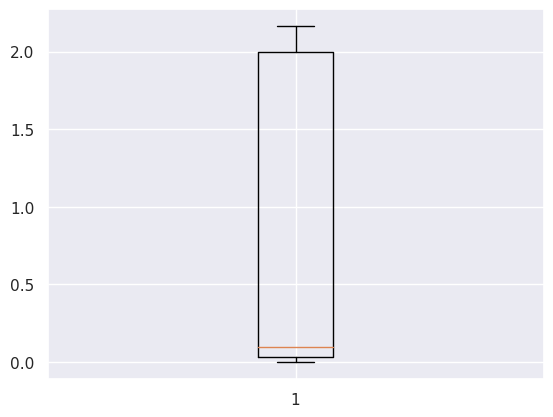

In [56]:
# Get the error on flow prediction.
for i in range(0,len(result_graphs)):
    graph = result_graphs[i]
    result_data = result_datas[i]
    result_epanet = result_epanets[i]
    re_list = []
    re = 0
    ne = 0
    diameterss = []
    for s,d,data in graph.edges(data = True):
        if abs(data['flow']) > 0 and data['diameter'] > 50:
            ne += 1
            re_list.append(abs(data['flow']-data['pre_flow']) / abs(data['flow']))
            re += abs(data['flow']-data['pre_flow']) / abs(data['flow'])
        diameterss.append(data['diameter'])
    print(np.median(re_list))
    plt.boxplot(re_list)
    print("Mean diameters:",np.mean(diameterss))

In [266]:
# [DMA] Save the graph in a pickle.
for i in range(0,len(result_graphs)):
    graph = result_graphs[i]
    result_data = result_datas[i]
    result_epanet = result_epanets[i]
    with open('./pickles/girona_toimprove.pkl', 'wb') as f:
        pickle.dump(graph, f)

In [624]:
# EPANET info about results.
for i in range(0,len(result_graphs)):
    result_graph = result_graphs[i]
    result_data = result_datas[i]
    result_epanet = result_epanets[i]
    b = 10000000
    print("Computing RS for budget:",b)
    g_attr_new = nx.Graph(g_attr)
    to_improve = nx.Graph(result_graph)
    impr_result_graph, impr_result_data, impr_result_epanet = zmod_algorithms.improve_resilience(g_attr_new, to_improve, b, wwtp, precomputed_data, result_data["total_cons"], debug=True)
    print(" - Failure rate is",result_data["failure_rate"])


Computing RS for budget: 10000000
 - Candidates evaluated: ( 1 / 197 ). Current cost: ( 172977 / 10000000 €).
 - Candidates evaluated: ( 1 / 141 ). Current cost: ( 188197 / 10000000 €).
 - Candidates evaluated: ( 1 / 140 ). Current cost: ( 215482 / 10000000 €).
 - Candidates evaluated: ( 1 / 132 ). Current cost: ( 222937 / 10000000 €).
 - Candidates evaluated: ( 1 / 131 ). Current cost: ( 233753 / 10000000 €).
 - Candidates evaluated: ( 1 / 124 ). Current cost: ( 244663 / 10000000 €).
 - Candidates evaluated: ( 1 / 122 ). Current cost: ( 251682 / 10000000 €).
 - Candidates evaluated: ( 1 / 118 ). Current cost: ( 263958 / 10000000 €).
 - Candidates evaluated: ( 1 / 117 ). Current cost: ( 268819 / 10000000 €).
 - Candidates evaluated: ( 1 / 115 ). Current cost: ( 284662 / 10000000 €).
 - Candidates evaluated: ( 1 / 113 ). Current cost: ( 306054 / 10000000 €).
 - Candidates evaluated: ( 1 / 109 ). Current cost: ( 339640 / 10000000 €).
 - Candidates evaluated: ( 1 / 108 ). Current cost: ( 

Running EPANET 2.2 ...
 - EPANET ran successfully
- Seems the output is OK, network is feasible.
 - Bad maximum speed, should be less than 1.2 and we obtained 2.78
To close: [(136, 2455), (807, 484)]


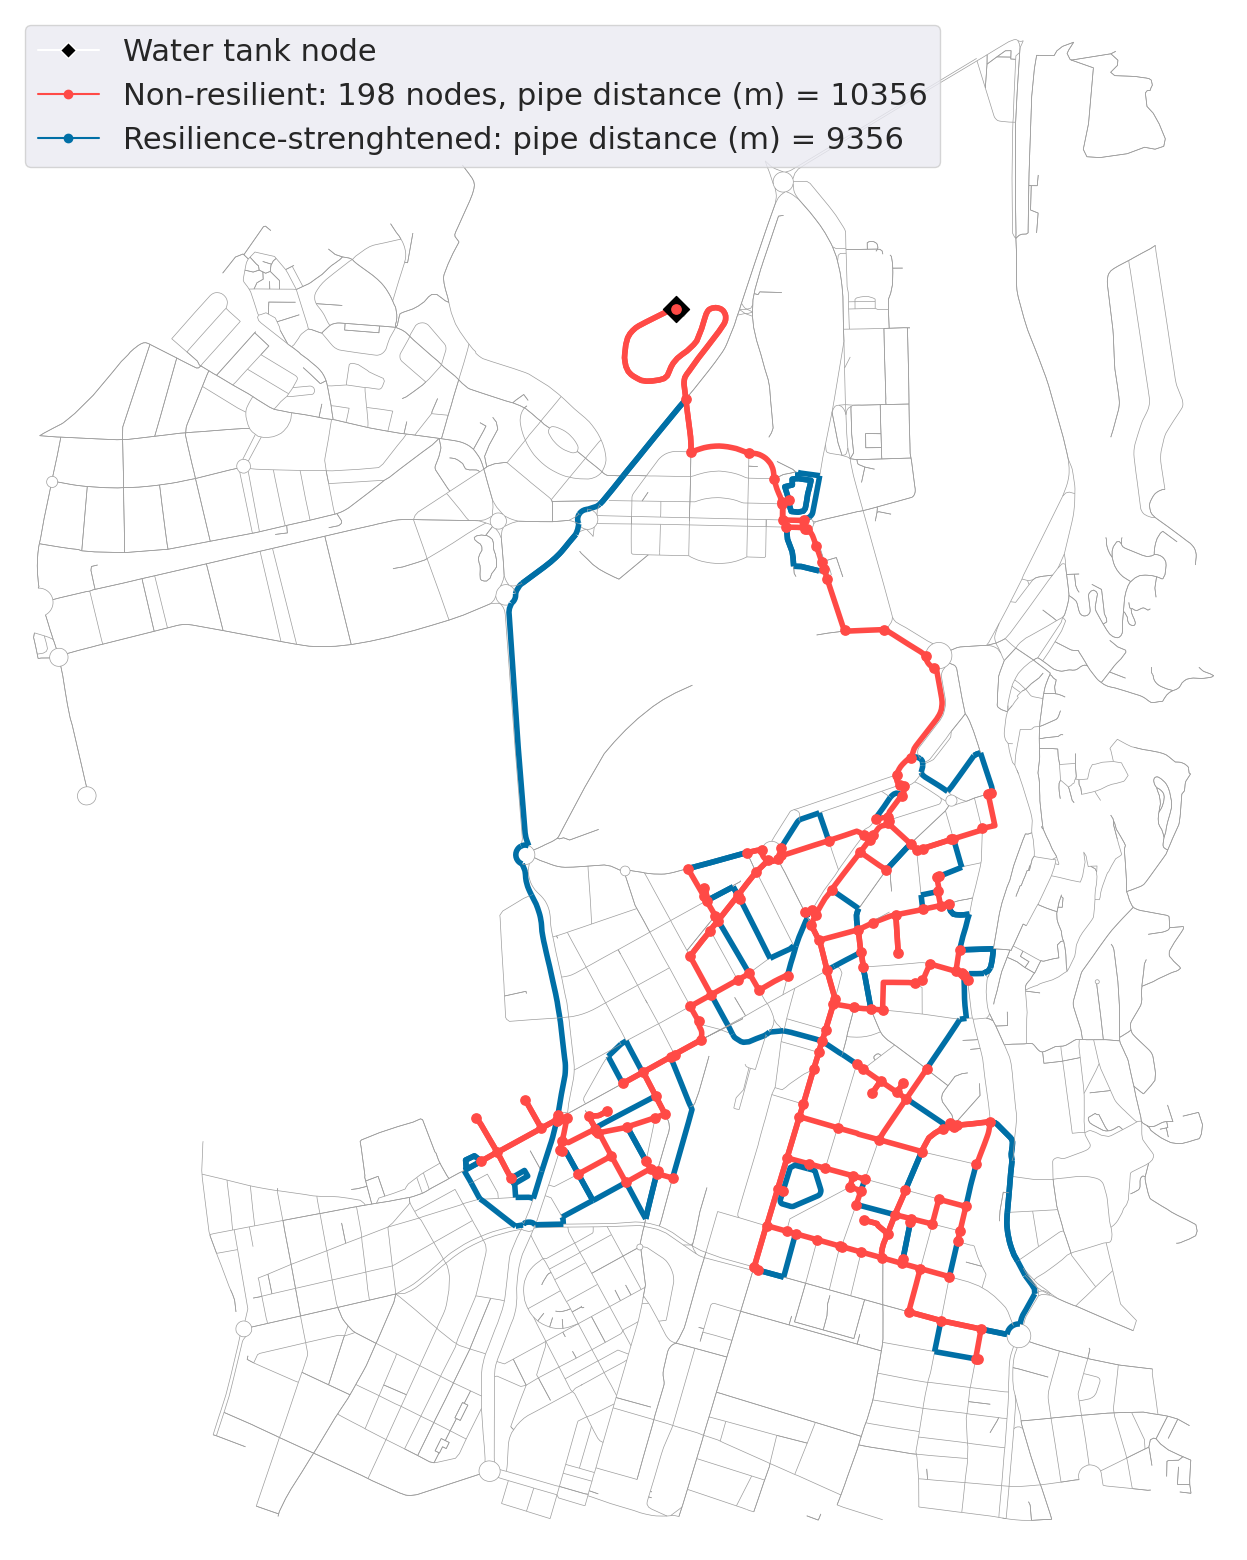

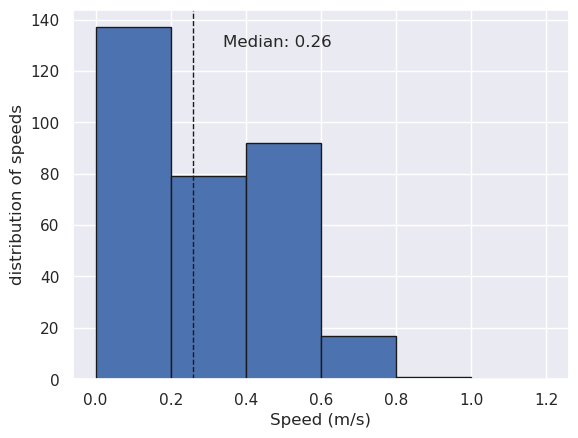

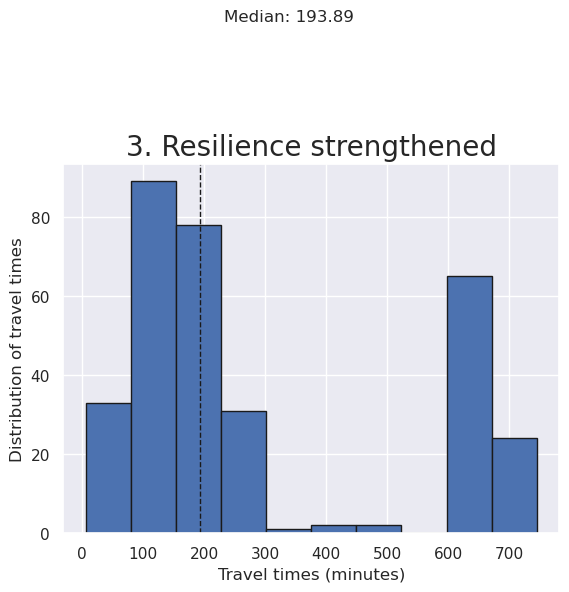

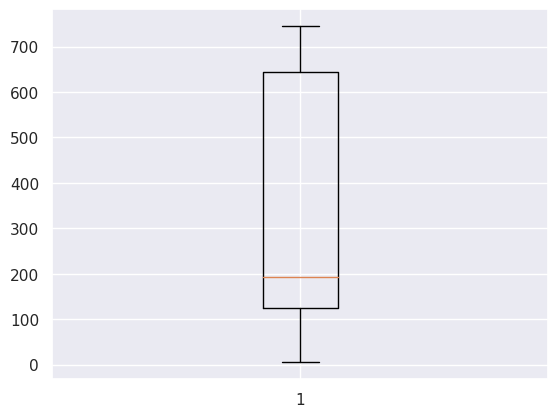

Maximum travel time (min): 745.25
***********************************************************************



In [680]:
# Result of the RS.
name = "resimpr"
title = "Resilience strengthened"
num = "3"
attrs = {}
to_close = []
node_data, link_data, epanet_result_data = zmod_epanet.compute_epanet(impr_result_graph, result_data["tank_capacity"], wwtp, True)
for u,v,data in impr_result_graph.edges(data=True):
    if link_data[(u,v)]["velocity"] > 0:
        travel_time = round(data["length"]/link_data[(u,v)]["velocity"]/60,2)
        attrs[(u,v)] = {
            "velocity": link_data[(u,v)]["velocity"],
            "pre_flow": round(data["flow"],2),
            "flow": link_data[(u,v)]["flow"],
            "headloss": link_data[(u,v)]["headloss"],
            "travel_time": travel_time,
            "popup_folium": "Diameter (mm): "+str(data["diameter"])+". Velocity (m/s): "+str(link_data[(u,v)]["velocity"])+". EPANET Flow (m3/d): "+str(abs(link_data[(u,v)]["flow"]))+". Predicted flow (m3/d): "+str(round(data["flow"],2))+". Pipe length (m): "+str(data["length"])+". Travel time (min): "+str(travel_time)+"."
        }
    else:
        attrs[(u,v)] = {
            "velocity": 0, 
            "flow": 0,
            "pre_flow": 0,
            "travel_time": 0,
            "popup_folium": "Closed Pipe (CP). Diameter (mm): "+str(data["diameter"])+". Pipe length (m): "+str(data["length"])+"."
        }
        to_close.append((u,v))
print("To close:",to_close)
nx.set_edge_attributes(impr_result_graph, attrs)

zmod_print.print_solution_small_impr(nx.MultiDiGraph(g_attr), wwtp, result_data["added_nodes"], wwtp, result_graph, impr_result_graph, filename="./pdfs/aa_"+name)

zmod_print.plot_network_with_folium_epanet(nx.Graph(g_attr), impr_result_graph, wwtp, precomputed_data, node_data, link_data, epanet_result_data["unsupplied_nodes"], "./htmls/aa_impr")
zmod_print.plot_network_with_folium_valves(nx.Graph(g_attr), impr_result_graph, wwtp, node_data, "./htmls/aa_impr_valves")


# Show a velocity histogram for information purposes.
velocities = []
for link in link_data:
    velocities.append(link_data[link]['velocity'])
bins = np.array([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2])
plt.hist(velocities, bins=bins, edgecolor = 'k', range = (0,1.2))
plt.axvline(np.median(velocities), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(np.median(velocities)*1.3, max_ylim*0.9, 'Median: {:.2f}'.format(np.median(velocities)))
plt.xlabel('Speed (m/s)')
plt.ylabel('distribution of speeds')
plt.show()

#  Generate a directed graph according to the flow values.
#  - The directed graph will be used to compute exploration time for each node.
directed_graph = nx.DiGraph()
for u,v,data in impr_result_graph.edges(data=True):
    flow = data['flow']
    if flow >= 0:
        directed_graph.add_edge(u, v)
    else:
        directed_graph.add_edge(v, u)
visited_nodes = set()
expl_times = []
stack = [(wwtp, 0)]
result = {}
while stack:
    current_node, current_time = stack.pop()
    if current_node not in visited_nodes:
        visited_nodes.add(current_node)
        accumulated_time = current_time
        for neighbor in directed_graph.neighbors(current_node):
            travel_time = impr_result_graph[current_node][neighbor]['travel_time']
            if travel_time > 0:
                total_time = round(accumulated_time + travel_time,2)
                if neighbor in result and total_time > result[neighbor]:
                        result[neighbor] = total_time
                else:
                    result[neighbor] = total_time
                expl_times.append(total_time)
                stack.append((neighbor, total_time))
travel_times[name] = expl_times
plt.hist(expl_times, edgecolor = 'k')
plt.axvline(np.median(expl_times), color='k', linestyle='dashed', linewidth=1)
plt.text(np.median(expl_times)*1.2, max_ylim*0.9, 'Median: {:.2f}'.format(np.median(expl_times)))
plt.xlabel('Travel times (minutes)')
plt.ylabel('Distribution of travel times')
plt.title(num+". "+title, size=20)
plt.savefig('pdfs/aa_traveltimes_resimpr'+name+'.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.boxplot(expl_times)
plt.show()
print('Maximum travel time (min):',max(expl_times))
print("***********************************************************************")
print()


In [644]:
g_attr_new = nx.Graph(g_attr)
print(zmod_availability.new_availability_weighted(impr_result_graph,precomputed_data,result_data["cons_nodes"],100000,impr_result_data["failure_rate"],wwtp, g_attr_new, impr_result_epanet))


Pipe failure probabilities (Q1,Q2,Q3): 1.9642591410851118e-05 3.87681054095923e-05 6.211583468318516e-05
Pipe failure probabilities (min,max): 8.832836537742139e-07 0.00048006480757711856
(0.9970264000000001, 0.99643, 0.99296, 647.2823793744536, 2.587818240412521, 1675.0491480428284)


In [432]:
longs = []
for node,data in g_attr.nodes(data=True):
    longs.append(data['x'])
print(min(longs),max(longs))

2.7865149 2.8508766


In [460]:
x = np.random.randn(1000, 3)
print(x)

[[ 0.07019293  0.00840553 -0.13967311]
 [ 0.39578882 -1.22480365 -0.73315527]
 [ 0.87664555  1.07004361 -0.46037288]
 ...
 [-1.1380047  -1.19658005  0.39180025]
 [-0.92596615 -0.04660605  0.01384805]
 [-0.25847311 -0.72019742 -0.39199323]]


In [508]:
print(travel_times)

{'nonresilient': [6.53, 10.44, 14.71, 17.35, 19.18, 19.3, 24.27, 20.51, 22.12, 22.8, 32.47, 22.95, 24.39, 25.64, 26.23, 26.99, 31.05, 34.0, 37.68, 38.76, 45.72, 47.39, 48.3, 48.64, 49.42, 51.12, 51.36, 61.57, 51.55, 53.13, 52.9, 53.29, 54.55, 53.71, 55.71, 58.62, 66.37, 58.88, 59.53, 60.56, 61.44, 65.44, 62.45, 64.02, 64.59, 65.5, 65.4, 67.77, 68.52, 75.08, 74.37, 67.86, 71.29, 72.74, 73.8, 75.13, 77.61, 87.81, 73.79, 75.02, 76.99, 77.32, 79.5, 84.1, 81.57, 83.24, 83.85, 85.72, 87.7, 88.05, 88.97, 91.47, 98.13, 94.72, 96.66, 96.63, 97.58, 105.13, 88.8, 92.56, 97.96, 95.84, 97.34, 97.5, 99.75, 100.3, 102.82, 109.95, 112.13, 106.14, 111.24, 99.51, 93.27, 102.82, 59.55, 57.55, 59.48, 60.16, 61.67, 65.54, 61.34, 64.92, 63.8, 66.2, 66.66, 67.55, 68.64, 69.54, 70.41, 71.75, 74.59, 75.66, 78.39, 78.07, 81.17, 83.66, 86.67, 88.25, 88.89, 94.96, 89.17, 92.0, 99.73, 93.56, 84.61, 88.21, 87.09, 92.86, 91.6, 97.06, 81.01, 79.37, 80.25, 82.19, 89.43, 83.5, 85.35, 88.92, 83.27, 92.78, 91.06, 84.59, 

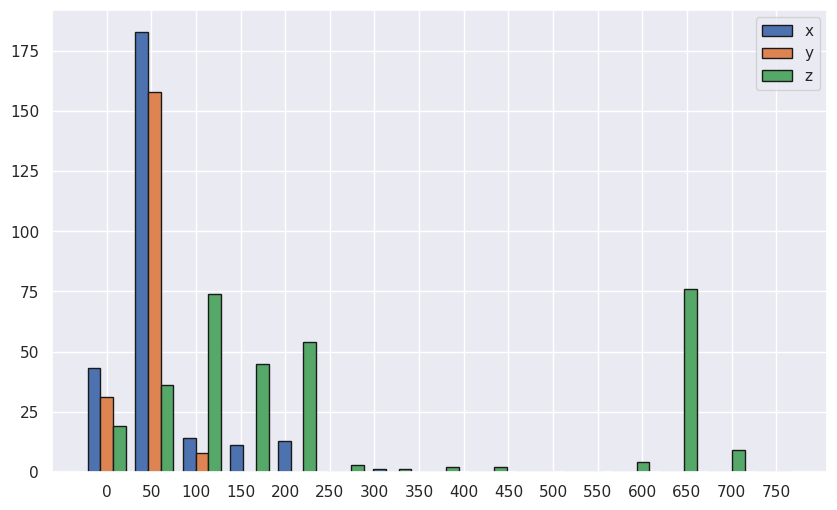

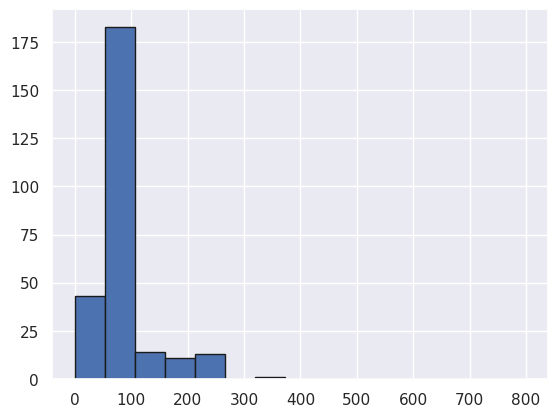

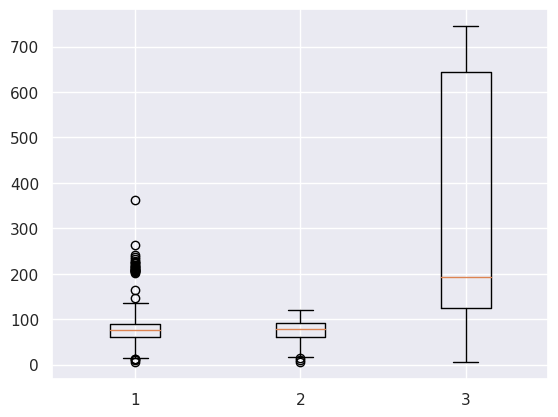

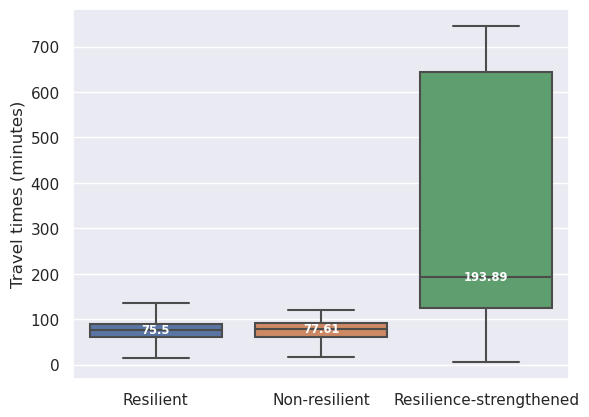

In [570]:
bins = np.linspace(0, 800, 16)

plt.figure(figsize=(10,6))
plt.hist([travel_times["resilient"], travel_times["nonresilient"], travel_times["resimpr"]], bins, align='left', label=['x', 'y', 'z'], edgecolor = 'k')
plt.legend(loc='upper right')
plt.xticks(range(0, 800, 50))
plt.show()
plt.close()

#plt.figure(figsize=(10,6))
plt.hist(travel_times["resilient"], bins, edgecolor = 'k')
#plt.xticks(range(0, 800, 50))
plt.show()
plt.close()

plt.boxplot([travel_times["resilient"], travel_times["nonresilient"], travel_times["resimpr"]])
plt.show()
plt.close()

medians = [np.median(travel_times["resilient"]), np.median(travel_times["nonresilient"]), np.median(travel_times["resimpr"])]
box_plot = sns.boxplot(showfliers=False,data=[travel_times["resilient"], travel_times["nonresilient"], travel_times["resimpr"]])
i = 0
box_plot.set_xticklabels(['Resilient','Non-resilient','Resilience-strengthened'])
box_plot.set(ylabel='Travel times (minutes)')
for xtick in box_plot.get_xticks():
    median = medians[i]
    box_plot.text(xtick,median - 7, median,
            horizontalalignment='center',size='x-small',color='w',weight='semibold')
    i += 1
plt.savefig('pdfs/aa_travelbox.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.close()

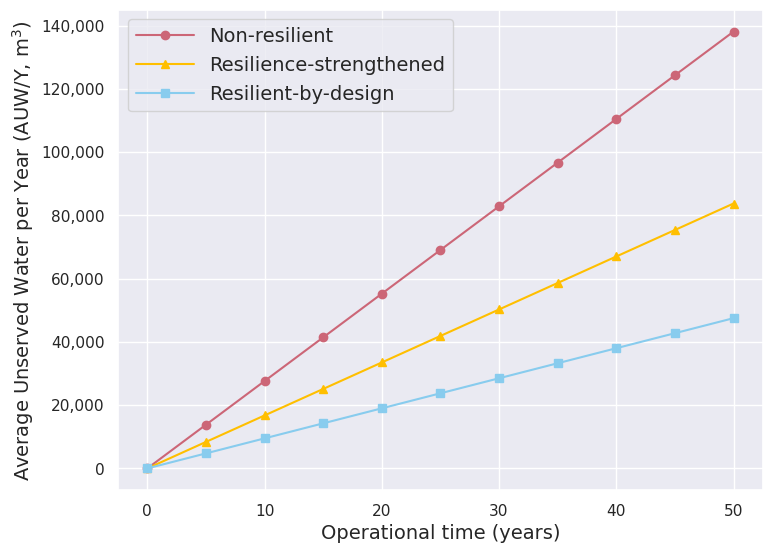

In [673]:
years = range(0,51,5)
a1 = [0,2762*5]
a2 = [0,1675*5]
a3 = [0,950*5]
for year in years:
    if year > 6:
        a1.append(a1[-1]+(2762*5))
        a2.append(a2[-1]+(1675*5))
        a3.append(a3[-1]+(950*5))

plt.plot(years, a1, color="#CC6677", label='Non-resilient', marker='o')
plt.plot(years, a2, color="#FFBF00", label='Resilience-strengthened', marker='^')
plt.plot(years, a3, color="#88CCEE", label='Resilient-by-design', marker='s')
plt.xlabel(r'Operational time (years)', fontsize=14)
plt.ylabel(r'Average Unserved Water per Year (AUW/Y, m$^3$)', fontsize=14)
plt.grid(True)
plt.legend(handlelength=3, loc="upper left",fontsize=14)
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
fig1 = plt.gcf()
zoom = 1.3
w, h = fig1.get_size_inches()
fig1.set_size_inches(w * zoom, h * zoom)
fig1.savefig('./pdfs/img_years.pdf', format="PDF", bbox_inches='tight')
plt.show()
